CNNによる人の顔分類を行うモデル

## import文

In [1]:
#import文
import glob
import pathlib
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from icrawler.builtin import BingImageCrawler
import cv2
import shutil
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping 
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization,MaxPooling2D,Activation,Dropout,Flatten
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import  load_model
from PIL import Image

## スクレイピング

８人分の顔分類を行うにあたり分類を行う人のリストを作る。
検索ワード用と画像格納パス指定用で2種類のリストを作り、
for文でスクレイピングを行う。
フォルダを開いて確認し複数人映っている画像や使い物にならなそうな画像は手作業で消す。

In [1]:
voice_lists_jp=['小倉唯 声優', '雨宮天 声優', '水瀬いのり 声優', '悠木碧 声優',
             '上坂すみれ　 声優', '佐倉綾音　 声優', '高橋李依　 声優', '伊藤美来 声優']
voice_lists=['ogurayui', 'amamiyasora', 'minaseinori', 'yuukiaoi',
             'uesakasumire', 'sakuraayane', 'takahasirie', 'itoumiku']
#スクレイピングを行う関数
def scraping(word, max_num, path):
    bing_crawler = BingImageCrawler(downloader_threads = 4, storage = {'root_dir': path})
    bing_crawler.crawl(keyword = word, filters = None, offset = 0, max_num = max_num,
                       min_size = (200, 200), max_size = None)

In [ ]:
# スクレイピング実行
for i in range(len(voice_lists)):
    scraping(voice_lists_jp[i], 500, './voice_picture/' + voice_lists[i] + '/')

## 顔領域の切り取り

In [524]:
# テストデータに使った元の画像確認したかったら最初にフォルダを移動させておいた方がいい
"""
#テストデータは別フォルダへ移動
os.makedirs("./voice_picture/valid", exist_ok = True)
for voice_list in voice_lists:
    in_dir = "./voice_picture/" + voice_list + "/*"
    in_img = glob.glob(in_dir)
    random.shuffle(in_img)
    os.makedirs('./voice_picture/valid/' + voice_list, exist_ok = True)
    for t in range(len(in_img) // 5):
        shutil.move(in_img[t], "./voice_picture/valid/" + voice_list)
        
#最終テストデータも別フォルダへ移動
os.makedirs("./voice_picture/test", exist_ok = True)
for voice_list in voice_lists:
    in_dir = "./voice_picture/" + voice_list + "/*"
    in_img = glob.glob(in_dir)
    random.shuffle(in_img)
    os.makedirs('./voice_picture/test/' + voice_list, exist_ok = True)
    for t in range(len(in_img)//10):
        shutil.move(in_img[t], "./voice_picture/test/" + voice_list)
"""

OpenCVの顔認識APIを用いて顔領域の切り取りを行う。横顔や傾いた顔は認識が難しい。またminNeighborsで誤認識の許容度を調整できるが厳しくすると取得枚数がぐっと減るため誤認識を大きく許容して後から誤認識画像は手動で削除することにする。テストデータに使用した画像を最後に確認したいため敢えてそれぞれで切り取りと保存を行ったが基本は切り取りしてからフォルダ移動でいいため一部コードは省略する（保存先パスなどは見直し必要）

In [27]:
#ディレクトリの中身を取得するメソッド
def get_file(dir_path):
    file = os.listdir(dir_path)
    return file

In [29]:
#訓練データ用
# 顔の切り取りと保存
for voice_list in voice_lists:
    os.mkdir("./voice_picture/kiziyo/" + voice_list + "_resize_64")
    #入力画像のディレクトリ
    in_dir = "voice_picture/" + voice_list + "/"
    #出力画像のディレクトリ
    out_dir = "voice_picture/kiziyo/" + voice_list + "_resize_64/"
    # 画像の取得
    pic = get_file(in_dir)
    n = 0

    for i in pic:
        # 画像の読み込み 
        image = cv2.imread(in_dir + i)
        # カスケードファイルの読み込み（顔認識）
        cascade = cv2.CascadeClassifier("./opencv-master/data/haarcascades/haarcascade_frontalface_alt.xml")
        # 顔認識の実行(scaleFactor:計算ステップ、minNeighbors:大きいほど誤検出少)
        # face_infoには4次元配列（x,y座標とそこからの縦横のサイズ)
        face_list = cascade.detectMultiScale(image, scaleFactor = 1.1, minNeighbors = 2, minSize = (1, 1))

        # 顔だけ切り出して保存
        for rect in face_list:
            n += 1
            x, y, width, height = rect
            face = image[y:y + height, x:x + width]
            face = cv2.resize(face, (64, 64))
            save_path = out_dir + 'resize_' + str(n) + '.jpg'
            cv2.imwrite(save_path, face)

In [527]:
#検証データ用
"""
# 顔の切り取りと保存
#def picture_cut(voice_lists):
## 入力
for voice_list in voice_lists:
    os.mkdir("./voice_picture/valid/" + voice_list + "_resize_64")
    #入力画像のディレクトリ
    in_dir = "voice_picture/valid/" + voice_list+"/"
    #出力画像のディレクトリ
    out_dir = "voice_picture/valid/" + voice_list + "_resize_64/"
    # 画像の取得
    pic = get_file(in_dir)
    n = 0

    for i in pic:
        # 画像の読み込み 
        image = cv2.imread(in_dir + i)
        # カスケードファイルの読み込み（顔認識）
        cascade = cv2.CascadeClassifier("./opencv-master/data/haarcascades/haarcascade_frontalface_alt.xml")
        # 顔認識の実行(scaleFactor:計算ステップ、minNeighbors:大きいほど誤検出少)
        # face_infoには4次元配列（x,y座標とそこからの縦横のサイズ)
        face_list = cascade.detectMultiScale(image, scaleFactor = 1.1, minNeighbors = 2, minSize = (1, 1))

        # 顔だけ切り出して保存
        for rect in face_list:
            n += 1
            x, y, width, height = rect
            face = image[y:y + height, x:x + width]
            face = cv2.resize(face, (64, 64))
            save_path = out_dir + 'resize_' + str(n) + '.jpg'
            cv2.imwrite(save_path, face)
""" 

In [528]:
#テストデータ用
"""
# 顔の切り取りと保存
#def picture_cut(voice_lists):
## 入力
for voice_list in voice_lists:
    os.mkdir("./voice_picture/test/" + voice_list + "_resize_64")
    #入力画像のディレクトリ
    in_dir = "voice_picture/test/" + voice_list+"/"
    #出力画像のディレクトリ
    out_dir = "voice_picture/test/" + voice_list + "_resize_64/"
    # 画像の取得
    pic = get_file(in_dir)
    n = 0

    for i in pic:
        # 画像の読み込み 
        image = cv2.imread(in_dir + i)
        # カスケードファイルの読み込み（顔認識）
        cascade = cv2.CascadeClassifier("./opencv-master/data/haarcascades/haarcascade_frontalface_alt.xml")
        # 顔認識の実行(scaleFactor:計算ステップ、minNeighbors:大きいほど誤検出少)
        # face_infoには4次元配列（x,y座標とそこからの縦横のサイズ)
        face_list = cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors = 2, minSize = (1, 1))

        # 顔だけ切り出して保存
        for rect in face_list:
            n += 1
            x, y, width, height = rect
            face = image[y:y + height, x:x + width]
            face = cv2.resize(face, (64, 64))
            save_path = out_dir + 'resize_'+str(n)+'.jpg'
            cv2.imwrite(save_path, face)
"""

手動で顔以外の画像は取り除く

## データの作成

最初にテストデータや検証データフォルダに移動させてない場合は顔領域切り取り後に移動

In [158]:
#テストデータは別フォルダへ移動
os.makedirs("./valid", exist_ok = True)
for voice_list in voice_lists:
    in_dir = "./voice_picture/" + voice_list + "_resize_64/*"
    in_img = glob.glob(in_dir)
    random.shuffle(in_img)
    os.makedirs('./voice_picture/valid_64/' + voice_list, exist_ok = True)
    for t in range(len(in_img) // 5):
        shutil.move(in_img[t], "./voice_picture/valid_64/" + voice_list)

In [159]:
#最終テストデータも別フォルダへ移動
os.makedirs("./test", exist_ok = True)
for voice_list in voice_lists:
    in_dir = "./voice_picture/" + voice_list + "_resize_64/*"
    in_img = glob.glob(in_dir)
    random.shuffle(in_img)
    os.makedirs('./voice_picture/test_64/' + voice_list, exist_ok = True)
    for t in range(len(in_img) // 10):
        shutil.move(in_img[t], "./voice_picture/test_64/" + voice_list)


## データの水増し

訓練データが100枚程度になってしまったため水増しを行う。ここでは-10度、0度、10度回転させた画像それぞれに対しぼかしや閾値処理などを行っている。

In [33]:
# 回転と閾値とぼかし
for voice_list in voice_lists:
    in_dir = "./voice_picture/" + voice_list + "_resize_64/*"
    out_dir = "./voice_picture/train_2/" + voice_list
    os.makedirs(out_dir, exist_ok = True)
    in_img = glob.glob(in_dir)
    for i in range(len(in_img)):
        img = cv2.imread(in_img[i])
        for ang in [-10, 0, 10]:
            h, w = img.shape[:2]
            M = cv2.getRotationMatrix2D(center = (w / 2, h / 2), angle = ang, scale = 1)
            img_rot = cv2.warpAffine(img, M, dsize=(64, 64))
            img_path = os.path.join(out_dir, str(i)+"_" + str(ang) + ".jpg")
            cv2.imwrite(img_path,img_rot)
            # 閾値
            img_thr = cv2.threshold(img_rot, 100, 255, cv2.THRESH_TRUNC)[1]
            img_path = os.path.join(out_dir, str(i) + "_" + str(ang) + "thr.jpg")
            cv2.imwrite(img_path, img_thr)
            # ぼかし
            img_gau = cv2.GaussianBlur(img_rot, (5, 5), 5)
            img_path=os.path.join(out_dir, str(i) + "_" + str(ang) + "gau.jpg")
            cv2.imwrite(img_path, img_gau)
            
            #グレースケール
            img_gray = cv2.cvtColor(img_rot, cv2.COLOR_BGR2GRAY) 
            img_path = os.path.join(out_dir, str(i) + "_" + str(ang) + "gray.jpg")
            cv2.imwrite(img_path, img_gray)
            
            #左右反転
            img_flip = cv2.flip(img_rot, 1)
            img_path = os.path.join(out_dir, str(i) + "_" + str(ang) + "flip.jpg")
            cv2.imwrite(img_path, img_flip)
            
            #ノイズ除去（カラー）
            img_denoise = cv2.fastNlMeansDenoisingColored(img_rot)
            img_path = os.path.join(out_dir, str(i) + "_" + str(ang) + "denoise.jpg")
            cv2.imwrite(img_path, img_denoise)

## ラベル付け

正解ラベルをRGB配列に対応付ける。to_categoricalではone-hotエンコーディング処理を行うことができる。

In [ ]:
X_train = [] 
Y_train = [] 
for i in range(len(voice_lists)):
    in_dir = "./voice_picture/train/" + voice_lists[i] + "/*"
    in_img  =glob.glob(in_dir)
    print(len(in_img))
    for j in range(len(in_img)):
        img = Image.open(in_img[j])        
        img = img.convert('RGB')
        data = np.asarray(img)
        X_train.append(data)
        Y_train.append(i)
        
# 検証データのラベル付け
X_val = [] # 画像データ読み込み
Y_val = [] # ラベル（名前）
for i in range(len(voice_lists)):
    in_dir = "./voice_picture/valid/" + voice_lists[i] + "_resize_64/*"
    in_img = glob.glob(in_dir)
    print(len(in_img))
    for j in range(len(in_img)):
        img = Image.open(in_img[j])        
        img = img.convert('RGB')
        data = np.asarray(img)
        X_val.append(data)
        Y_val.append(i)
        
# テストデータのラベル付け
X_test = [] # 画像データ読み込み
Y_test = [] # ラベル（名前）
for i in range(len(voice_lists)):
    in_dir = "./voice_picture/test/" + voice_lists[i] + "_resize_64/*"
    in_img = glob.glob(in_dir)
    print(len(in_img))
    for j in range(len(in_img)):
        img = Image.open(in_img[j])        
        img = img.convert('RGB')
        data = np.asarray(img)
        X_test.append(data)
        Y_test.append(i)

x_train = np.array(X_train)
x_val = np.array(X_val)
x_test = np.array(X_test)
y_train = to_categorical(Y_train)
y_val = to_categorical(Y_val)
y_test = to_categorical(Y_test)

## モデル構築と学習

TensorflowでSequentialモデルを作成。バッチ正規化層は勾配の消失や発散を防ぐとともに学習を早める効果がある。

In [79]:
# モデルの定義
model = Sequential()

model.add(Conv2D(input_shape = (64, 64, 3), filters = 32,kernel_size = (3, 3),strides = (1, 1), padding = "same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = "same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = "same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size  =(2, 2)))

model.add(Flatten())
#model.add(GlobalAveragePooling2D())

model.add(Dense(256))
model.add(Activation('sigmoid'))
model.add(Dense(128))
model.add(Activation('sigmoid'))
model.add(Dense(8))
model.add(Activation('softmax'))

# コンパイル
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.summary()

In [ ]:
# 学習
history = model.fit(x_train, y_train, batch_size = 32, 
                         epochs = 100, verbose = 1, validation_data = (x_val, y_val),
                         callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 7)])

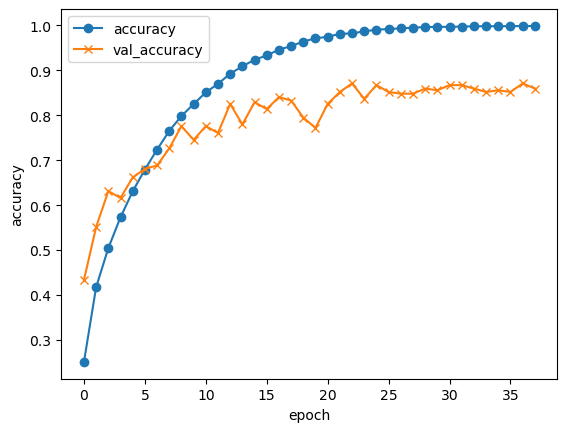

In [82]:
#acc, val_accのプロット
plt.plot(history.history["accuracy"], label="accuracy", ls="-", marker="o")
plt.plot(history.history["val_accuracy"], label="val_accuracy", ls="-", marker="x")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc="best")
plt.show()

#モデルを保存
model.save("my_model_CNN.h5")

## テスト

## 正答率確認

In [ ]:
#93枚テストデータの正答率確認
y_pred = model.predict(x_test)
y_pred_max = np.argmax(y_pred, axis = 1)

In [ ]:
y_test_max = np.argmax(y_test, axis = 1)
y_test_max

In [86]:
#テストデータ77枚の正答率
accuracy = accuracy_score(y_test_max, y_pred_max)
print('テストデータでの正答率:', accuracy)

テストデータでの正答率: 0.8602150537634409


In [21]:
voice_lists_jp = ['小倉唯', '雨宮天', '水瀬いのり', '悠木碧',
             '上坂すみれ', '佐倉綾音', '高橋李依', '伊藤美来']

In [ ]:
#間違えた画像を確認する
for i in range(len(y_pred_max)):
    if y_pred_max[i] != y_test_max[i]:
        print(voice_lists_jp[y_test_max[i]] + "を" + voice_lists_jp[y_pred_max[i]] + "と誤って予測した")
        plt.imshow(x_test[i])
        plt.show()

## 読み込んだ画像を認識させる

In [30]:
voice_lists = ['Ogura Yui', 'Amamiya Sora', 'Minase Inori', 'Yuki Aoi',
             'Uesaka Sumire', 'Sakura Ayane', 'Takahashi Rie', 'Itou Miku']

コードが長くなるがif文で1つ1つ定義したほうが処理としては早い

In [73]:
#予測メソッド
def face_who(img):
    name_index = np.argmax(model.predict(img))
    for i in range(len(voice_lists)):
        if name_index == i:
            name = voice_lists[i]
    #多分こっちのが早いがコードが長い
    """
    if name_index == 0: 
        name  ="Ogura Yui"
    elif name_index == 1:
        name = "Amamiya Sora"
    elif name_index == 2:
        name = "Minase Inori"
    elif name_index == 3:
        name = "Yuki Aoi"
    elif name_index == 4:
        name = "Uesaka Sumire"
    elif name_index == 5:
        name = "Sakura Ayane"
    elif name_index == 6:
        name = "Takahashi Rie"
    elif name_index == 7:
        name = "Ito Miku"
    """
    return name

In [74]:
#読み込んだ画像に対して誰か表示
def discriminate_face(img):
    img = img.convert('RGB')
    data = np.asarray(img)
    cascade = cv2.CascadeClassifier("./opencv-master/data/haarcascades/haarcascade_frontalface_alt.xml")
    face_list = cascade.detectMultiScale(data, scaleFactor = 1.1, minNeighbors = 3, minSize = (1, 1))
    if len(face_list) > 0:
        for rect in face_list:
            x, y, width, height = rect
            cv2.rectangle(data, (x, y), (x + width, y + height), (255, 0, 0), thickness = 5)
            image_cut = data[y:y + height, x:x + width]
            image_resize = cv2.resize(image_cut, (64, 64)) 
            image_resize = np.expand_dims(image_resize, axis = 0)
            name = face_who(image_resize)
            cv2.putText(data, name, (x, y + height + 60), cv2.FONT_HERSHEY_DUPLEX, 2, (0, 255, 0), 5)
            #cv2.rectangle(data, (x, y), (x + width, y + height), (255, 0, 0), thickness = -1)
    return data

1/1 [==============================] - 0s 228ms/step


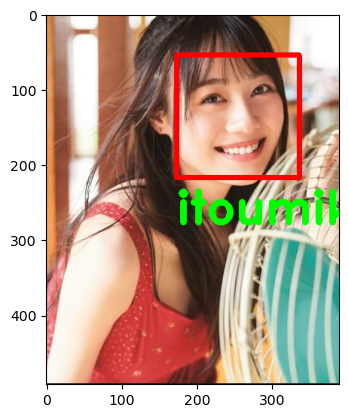

In [75]:
model = load_model('./my_model_miura.h5')
image = Image.open("./voice_picture/check/47.jpg")
whoImage = discriminate_face(image)
plt.imshow(whoImage)
plt.show()

カメラに移った画像をリアルタイムで判定させる

In [35]:
def main():
    # 学習済みモデルの読み込み
    model = load_model('./my_model.h5')
    #Webカメラの映像表示
    capture = cv2.VideoCapture(0)
    if capture.isOpened() is False:
            raise("IO Error")
    while True:
        #Webカメラの映像とりこみ
        ret, image = capture.read()
        if ret == False:
            continue
        k = cv2.waitKey(10)
        face = Image.fromarray(image)
        whoImage = discriminate_face(face)
        cv2.imshow('CHECK',whoImage)
        #ESCキーでキャプチャー画面を閉じる
        if  k == 27:
            break
    cv2.destroyAllWindows()

if __name__ == '__main__':
    main()

1/1 [==============================] - 0s 47ms/step


## 学習済モデルの利用

### ResNet

In [16]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import optimizers

In [17]:
input_tensor = Input(shape = (64, 64, 3))
base_model = ResNet50(include_top = False, weights = 'imagenet', input_tensor = input_tensor)

In [ ]:
# 学習済み重みを利用する場合は層の訓練可能を"False"とする
for layer in base_model.layers[:146]:
    layer.trainable = False
    # Batch Normalization の freeze解除
    if 'bn' in layer.name:
        layer.trainable = True
for layer in base_model.layers[0:]:
    layer.trainable = True
# 何層目までFalseとしたか確認用
for layer in base_model.layers:
    print(layer, layer.trainable )

In [25]:
model = Sequential()

model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation = 'softmax'))

In [ ]:
# モデル
model.summary()

In [26]:
model.compile(optimizer = optimizers.SGD(learning_rate=0.001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, batch_size = 32, 
                    epochs = 100, verbose = 1, validation_data = (x_val, y_val),
                    callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 7)])

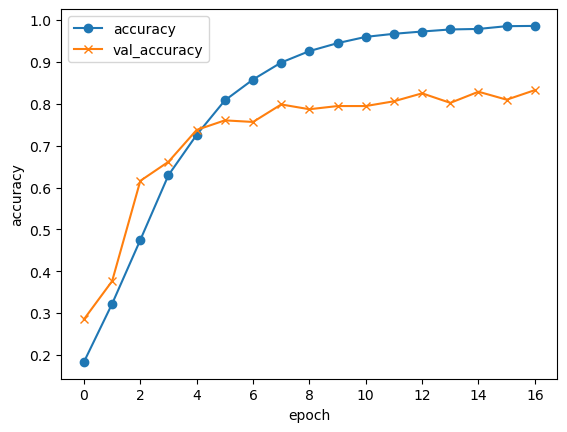

In [28]:
#acc, val_accのプロット
plt.plot(history.history["accuracy"], label = "accuracy", ls = "-", marker="o")
plt.plot(history.history["val_accuracy"], label = "val_accuracy", ls = "-", marker = "x")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(loc = "best")
plt.show()

#モデルを保存
model.save("my_model_resnet_all.h5")
model.save_weights('model_weight_resnet_all.hdf5')

In [52]:
full_model.save_weights('model_weight_{}.hdf5'.format(100))

In [71]:
#93枚テストデータの正答率確認
y_pred = model.predict(x_test)
y_pred_max = np.argmax(y_pred, axis = 1)
y_test_max = np.argmax(y_test, axis = 1)

3/3 [==============================] - 10s 397ms/step


In [72]:
accuracy = accuracy_score(y_test_max, y_pred_max)
print('テストデータでの正答率:', accuracy)

テストデータでの正答率: 0.7634408602150538


In [ ]:
#間違えた画像を確認する
for i in range(len(y_pred_max)):
    if y_pred_max[i] != y_test_max[i]:
        print(voice_lists_jp[y_test_max[i]] + "を" + voice_lists_jp[y_pred_max[i]] + "と誤って予測した")
        plt.imshow(x_test[i])
        plt.show()

### VGG16(使い方の参考)

In [2]:
from keras.applications.vgg16 import VGG16
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras import optimizers

In [3]:
input_tensor = Input(shape = (64, 64, 3))
vgg16 = VGG16(include_top = False, weights = 'imagenet', input_tensor = input_tensor)

In [5]:
top_model = Sequential()
top_model.add(Flatten(input_shape = vgg16.output_shape[1:]))
top_model.add(Dense(1024, activation = 'relu'))
top_model.add(Dense(256, activation = 'relu'))
top_model.add(Dense(128, activation = 'relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(8, activation = 'softmax'))

model = Model(inputs = vgg16.input, outputs = top_model(vgg16.output))

# modelの16層目までがvggのモデル
for layer in model.layers[:15]:
    layer.trainable = False
    
#model.compile(loss='categorical_crossentropy',
#              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
#              metrics=['accuracy'])
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])

## Grad CAM

In [1]:
# 画像を読み込んで予測する
def img_predict(filename):
    img = cv2.imread(filename)
    x   = np.expand_dims(img, axis=0)
    # 表示
    cv2_imshow(img)
    pred = model.predict(x)[0]

In [2]:
IMAGE_SIZE = (64,64)
# 層を指定して、そこで見ている箇所を可視化
target_layer = 'conv5_block3_3_conv'

In [3]:
import numpy as np
import cv2
import argparse
import keras
import sys
from keras import backend as K
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import load_model
from tensorflow.keras import models
import tensorflow as tf

In [4]:
IMAGE_SIZE = (64,64)

def grad_cam(input_model, x, layer_name = target_layer):
    """
    Args: 
        input_model(object): モデルオブジェクト
        x(ndarray): 画像
        layer_name(string): 畳み込み層の名前
    Returns:
        output_image(ndarray): 元の画像に色付けした画像
    """

    # 画像の前処理
    # 読み込む画像が1枚なため、次元を増やしておかないとmode.predictが出来ない
    X = np.expand_dims(x, axis = 0)
    preprocessed_input = X.astype('float32') / 255.0    

    grad_model = models.Model([input_model.inputs], [input_model.get_layer(layer_name).output, input_model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(preprocessed_input)
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]

    # 勾配を計算
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')

    guided_grads = gate_f * gate_r * grads

    # 重みを平均化して、レイヤーの出力に乗じる
    weights = np.mean(guided_grads, axis=(0, 1))
    cam = np.dot(output, weights)

    # 画像を元画像と同じ大きさにスケーリング
    cam = cv2.resize(cam, IMAGE_SIZE, cv2.INTER_LINEAR)
    # ReLUの代わり
    cam  = np.maximum(cam, 0)
    # ヒートマップを計算
    heatmap = cam / cam.max()

    # モノクロ画像に疑似的に色をつける
    jet_cam = cv2.applyColorMap(np.uint8(255.0*heatmap), cv2.COLORMAP_JET)
    # RGBに変換
    rgb_cam = cv2.cvtColor(jet_cam, cv2.COLOR_BGR2RGB)
    # もとの画像に合成
    output_image = (np.float32(rgb_cam) + x / 2)  

    return output_image

In [5]:
#読み込んだ画像に対して誰か表示
def discriminate_face(img):
    img = img.convert('RGB')
    data = np.asarray(img)
    cascade = cv2.CascadeClassifier("./opencv-master/data/haarcascades/haarcascade_frontalface_alt.xml")
    face_list = cascade.detectMultiScale(data, scaleFactor = 1.1, minNeighbors = 3, minSize = (1, 1))
    if len(face_list) > 0:
        for rect in face_list:
            x, y, width, height = rect
            cv2.rectangle(data, (x, y), (x + width, y + height), (255, 0, 0), thickness = 5)
            image_cut = data[y:y + height, x:x + width]
            image_resize = cv2.resize(image_cut, (64, 64)) 
            image_resize = np.expand_dims(image_resize, axis = 0)
            name = face_who(image_resize)
            cv2.putText(data, name, (x, y + height + 60), cv2.FONT_HERSHEY_DUPLEX, 2, (0, 255, 0), 5)
            #cv2.rectangle(data, (x, y), (x + width, y + height), (255, 0, 0), thickness = -1)
    return data

In [6]:
def grad_cam(input_model, x, layer_name):
    """
    Args: 
        input_model(object): モデルオブジェクト
        x(ndarray): 画像
        layer_name(string): 畳み込み層の名前
    Returns:
        output_image(ndarray): 元の画像に色付けした画像
    """

    # 画像の前処理
    # 読み込む画像が1枚なため、次元を増やしておかないとmode.predictが出来ない
    X = np.expand_dims(x, axis=0)
    preprocessed_input = X.astype('float32') / 255.0    

    grad_model = models.Model([input_model.inputs], [input_model.get_layer(layer_name).output, input_model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(preprocessed_input)
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]

    # 勾配を計算
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')

    guided_grads = gate_f * gate_r * grads

    # 重みを平均化して、レイヤーの出力に乗じる
    weights = np.mean(guided_grads, axis = (0, 1))
    cam = np.dot(output, weights)

    # 画像を元画像と同じ大きさにスケーリング
    cam = cv2.resize(cam, IMAGE_SIZE, cv2.INTER_LINEAR)
    # ReLUの代わり
    cam  = np.maximum(cam, 0)
    # ヒートマップを計算
    heatmap = cam / cam.max()

    # モノクロ画像に疑似的に色をつける
    jet_cam = cv2.applyColorMap(np.uint8(255.0*heatmap), cv2.COLORMAP_JET)
    # RGBに変換
    rgb_cam = cv2.cvtColor(jet_cam, cv2.COLOR_BGR2RGB)
    # もとの画像に合成
    output_image = (np.float32(rgb_cam) + x / 2)  

    return output_image
 

In [7]:
image_path = './voice_picture/test/minaseinori_resize_64/resize_3.jpg'
IMAGE_SIZE  = (64, 64)

model1=load_model('my_model_CNN.h5')
x = img_to_array(load_img(image_path, target_size=IMAGE_SIZE))

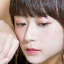

In [8]:
array_to_img(x)

#### 自分のモデルの結果

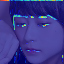

In [218]:
target_layer = 'conv2d'
cam = grad_cam(model1, x, target_layer)
array_to_img(cam)

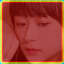

In [219]:
target_layer = 'conv2d_1'
cam = grad_cam(model1, x, target_layer)
array_to_img(cam)

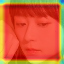

In [220]:
target_layer = 'conv2d_2'
cam = grad_cam(model1, x, target_layer)
array_to_img(cam)

In [212]:
image_path = './voice_picture/test/amamiyasora_resize_64/resize_4.jpg'
IMAGE_SIZE  = (64, 64)
model=load_model('my_model_resnet.h5')
x = img_to_array(load_img(image_path, target_size=IMAGE_SIZE))

#### resnet50の結果

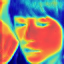

In [222]:
target_layer = 'conv1_conv'
cam = grad_cam(model, x, target_layer)
array_to_img(cam)

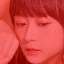

In [231]:
target_layer = 'conv2_block1_1_conv'
cam = grad_cam(model, x, target_layer)
array_to_img(cam)

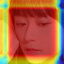

In [232]:
target_layer = 'conv2_block3_3_conv'
cam = grad_cam(model, x, target_layer)
array_to_img(cam)

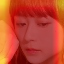

In [233]:
target_layer = 'conv3_block1_1_conv'
cam = grad_cam(model, x, target_layer)
array_to_img(cam)

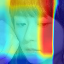

In [234]:
target_layer = 'conv3_block3_3_conv'
cam = grad_cam(model, x, target_layer)
array_to_img(cam)

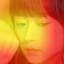

In [236]:
target_layer = 'conv4_block1_1_conv'
cam = grad_cam(model, x, target_layer)
array_to_img(cam)

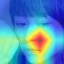

In [237]:
target_layer = 'conv4_block3_3_conv'
cam = grad_cam(model, x, target_layer)
array_to_img(cam)

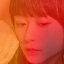

In [238]:
target_layer = 'conv5_block1_1_conv'
cam = grad_cam(model, x, target_layer)
array_to_img(cam)

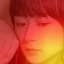

In [239]:
target_layer = 'conv5_block3_3_conv'
cam = grad_cam(model, x, target_layer)
array_to_img(cam)